# Previsão do Nível do Rio em Rio do Sul com Regressão Linear

**Observação importante:** Todos os dados de nível do rio neste projeto estão em decímetros (dm) e as chuvas em milímetros (mm). Todas as previsões e análises consideram essas unidades. Para converter o nível do rio para metros, divida o valor por 10.

Este notebook tem como objetivo prever o nível do rio em Rio do Sul utilizando dados reais de nível do rio e chuvas, aplicando técnicas de regressão linear. O processo inclui análise exploratória, tratamento de dados, treinamento e avaliação de modelos, além de uma aplicação PHP para previsão.

## Carregando o Dataset

Nesta etapa, vamos carregar o arquivo `dados.csv` e apresentar uma breve visão geral do dataset.

In [1]:
import pandas as pd

# Lê o CSV com separador padrão e converte vírgula decimal para ponto
raw = pd.read_csv('dados.csv', dtype=str)
for col in raw.columns:
    raw[col] = raw[col].str.replace('"', '').str.replace(',', '.').astype(float)
df = raw.copy()
df.head()

,NivelRiodoSul,NívelItuporanga,ChuvaItuporanga,NívelTaió,ChuvaTaió
0,170.0,30.0,3.0,98.0,0.0
1,170.0,39.0,12.0,98.0,0.0
2,169.0,59.0,19.0,98.0,0.0
3,169.0,82.0,5.0,98.0,0.0
4,169.0,27.0,1.0,97.0,0.0


## Tratamento de Dados: Valores Faltantes, Duplicatas e Inconsistências

Aqui, vamos identificar e tratar valores faltantes, duplicatas e outras inconsistências relevantes nos dados.

In [2]:
# Verificando valores faltantes e duplicatas
df = df.drop_duplicates()
missing = df.isnull().sum()
if missing.any():
    df = df.fillna(df.median())
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40277 entries, 0 to 65405
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   NivelRiodoSul    40277 non-null  float64
 1   NívelItuporanga  40277 non-null  float64
 2   ChuvaItuporanga  40277 non-null  float64
 3   NívelTaió        40277 non-null  float64
 4   ChuvaTaió        40277 non-null  float64
dtypes: float64(5)
memory usage: 1.8 MB


## Análise Exploratória: Histograma do Nível do Rio

Vamos visualizar a distribuição da variável alvo (nível do rio em Rio do Sul) utilizando um histograma.

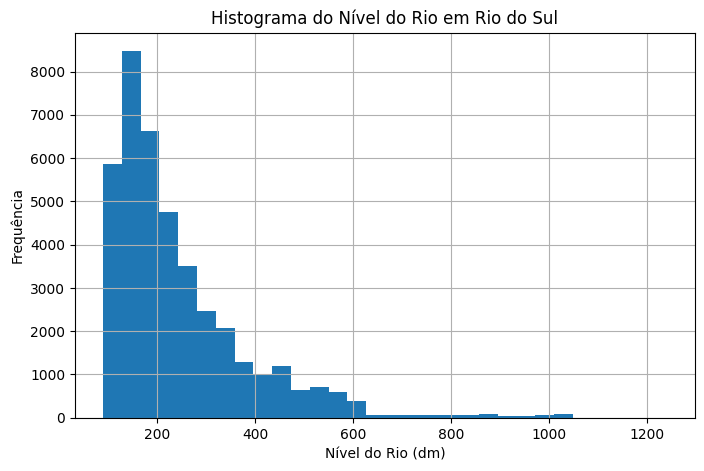

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
df['NivelRiodoSul'].hist(bins=30)
plt.title('Histograma do Nível do Rio em Rio do Sul')
plt.xlabel('Nível do Rio (dm)')
plt.ylabel('Frequência')
plt.show()

## Análise Exploratória: Scatter Plots

Nesta etapa, criaremos scatter plots para analisar a relação entre o nível do rio e as variáveis de entrada.

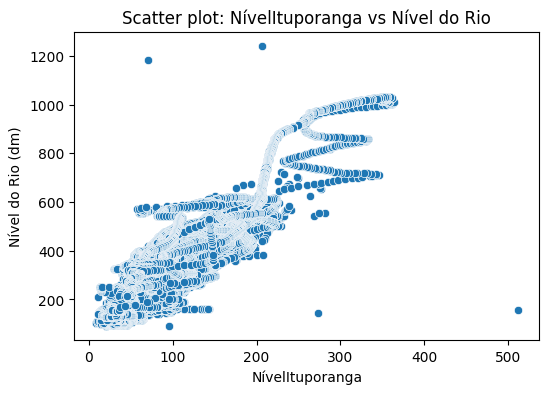

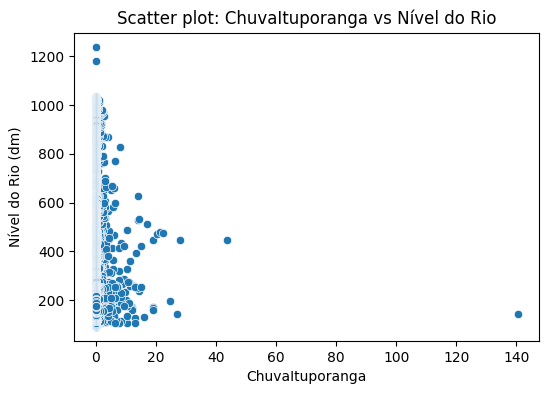

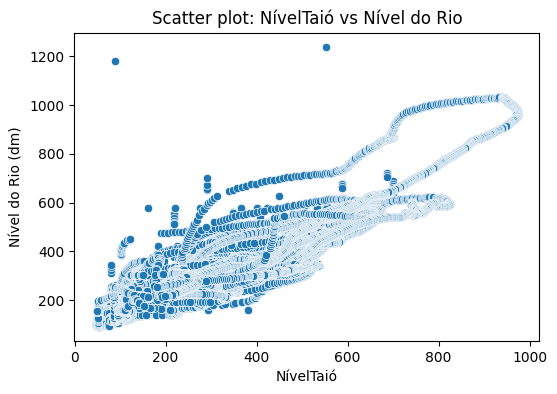

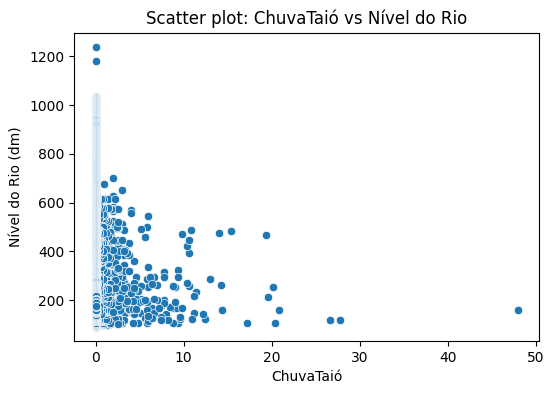

In [4]:
import seaborn as sns

features = [col for col in df.columns if col != 'NivelRiodoSul']
for feature in features:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=df[feature], y=df['NivelRiodoSul'])
    plt.title(f'Scatter plot: {feature} vs Nível do Rio')
    plt.xlabel(feature)
    plt.ylabel('Nível do Rio (dm)')
    plt.show()

## Análise Exploratória: Heatmap de Correlação

Vamos gerar um heatmap de correlação para identificar relações entre as variáveis do dataset.

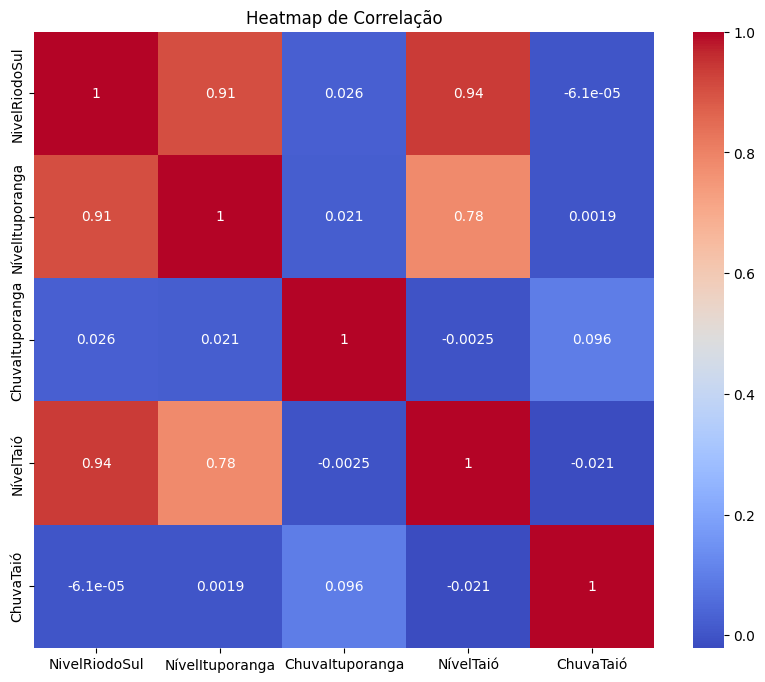

In [5]:
import numpy as np

plt.figure(figsize=(10,8))
corr = df.corr()
if not corr.empty:
    sns.heatmap(corr, annot=True, cmap='coolwarm')
    plt.title('Heatmap de Correlação')
    plt.show()
else:
    print('Não há colunas numéricas suficientes para gerar o heatmap.')

## Análise Exploratória: Boxplots

Aqui, utilizaremos boxplots para identificar possíveis outliers e entender a distribuição das variáveis.

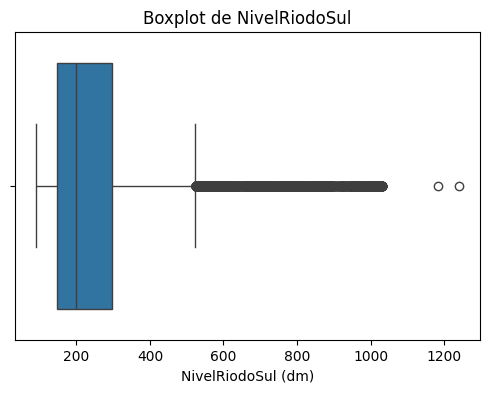

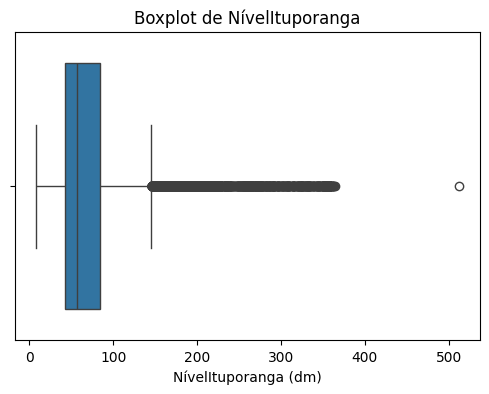

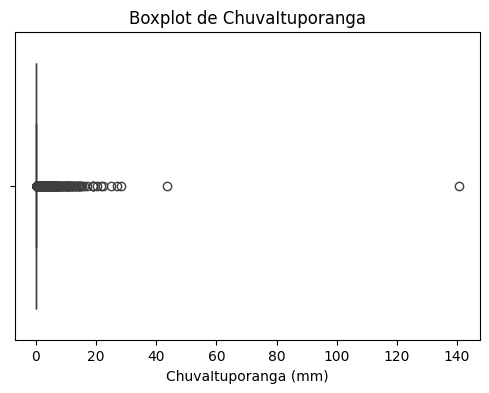

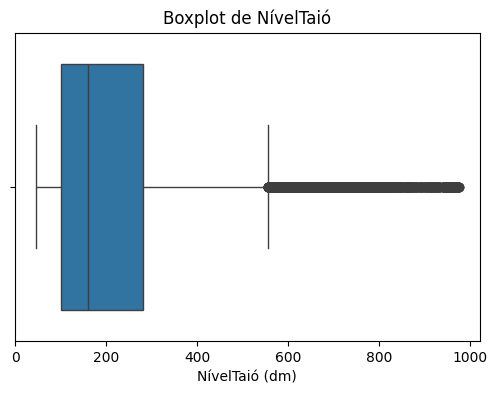

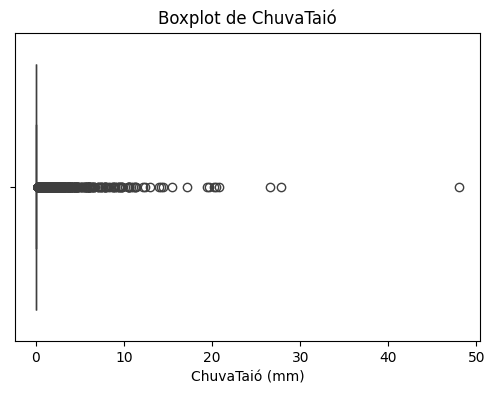

In [6]:
numeric_cols = df.select_dtypes(include='number').columns
for col in numeric_cols:
    plt.figure(figsize=(6,4))
    if 'Chuva' in col:
        plt.xlabel(f'{col} (mm)')
    else:
        plt.xlabel(f'{col} (dm)')
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot de {col}')
    plt.show()

## Pré-processamento: Normalização/Padronização das Variáveis de Entrada

Nesta etapa, vamos normalizar ou padronizar as variáveis de entrada para melhorar o desempenho do modelo.

In [7]:
from sklearn.preprocessing import StandardScaler

X = df.drop('NivelRiodoSul', axis=1)
y = df['NivelRiodoSul']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

## Divisão do Dataset em Treinamento e Teste

Vamos dividir o dataset em conjuntos de treinamento (70%) e teste (30%) para avaliar o modelo.

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Treinamento do Modelo de Regressão Linear

Aqui, treinaremos um modelo de regressão linear utilizando os dados de treinamento.

In [9]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


## Avaliação do Modelo: Métricas de Regressão

Vamos avaliar o desempenho do modelo utilizando métricas como RMSE, MAE e R².

## Observação sobre Outliers e Desbalanceamento dos Dados

Apesar do modelo apresentar um R² alto (0.96), o erro absoluto médio (MAE) ainda é significativo para a escala dos dados. Isso pode indicar a presença de outliers (valores extremos) ou desbalanceamento no dataset, o que pode levar a previsões irreais em situações de entrada fora do padrão dos dados históricos. Recomenda-se analisar e remover outliers, além de garantir que o dataset contenha exemplos variados de níveis baixos e altos para melhorar a robustez e realismo das previsões.

## Remoção de Outliers e Balanceamento dos Dados

Para melhorar a robustez e o realismo das previsões, vamos remover outliers das variáveis numéricas usando o método do IQR (Intervalo Interquartil) e, em seguida, balancear o dataset para garantir que haja exemplos suficientes de níveis baixos, médios e altos do rio. Após esse tratamento, re-treinaremos o modelo e avaliaremos novamente seu desempenho.

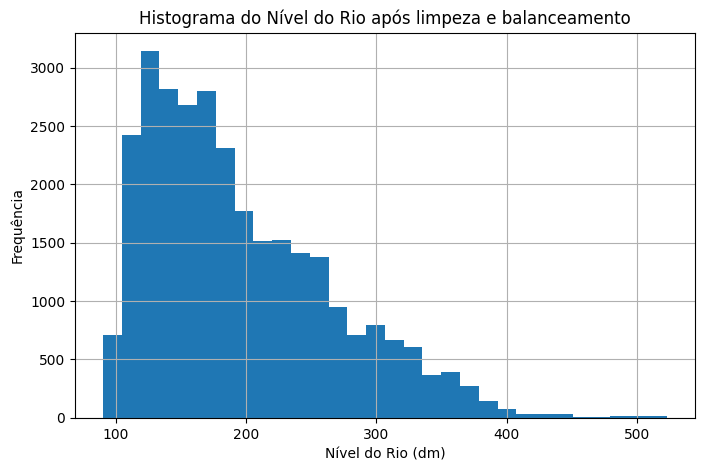

In [10]:
# Remoção de outliers usando o método do IQR para todas as variáveis numéricas
from copy import deepcopy

df_clean = deepcopy(df)
for col in df_clean.select_dtypes(include='number').columns:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]

# Balanceamento: garantir exemplos de níveis baixos, médios e altos
# Definindo faixas de nível do rio
quantiles = df_clean['NivelRiodoSul'].quantile([0.33, 0.66]).values

def faixa_nivel(valor):
    if valor <= quantiles[0]:
        return 'baixo'
    elif valor <= quantiles[1]:
        return 'medio'
    else:
        return 'alto'

df_clean['faixa'] = df_clean['NivelRiodoSul'].apply(faixa_nivel)
min_count = df_clean['faixa'].value_counts().min()
df_bal = df_clean.groupby('faixa').sample(n=min_count, random_state=42)

# Visualização após limpeza
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
df_bal['NivelRiodoSul'].hist(bins=30)
plt.title('Histograma do Nível do Rio após limpeza e balanceamento')
plt.xlabel('Nível do Rio (dm)')
plt.ylabel('Frequência')
plt.show()

## Re-treinamento e Avaliação do Modelo Após Limpeza e Balanceamento
Após remover outliers e balancear o dataset, vamos normalizar novamente as variáveis de entrada, dividir os dados em treino e teste, treinar o modelo de regressão linear e avaliar as métricas de desempenho.

In [11]:
# Normalização, divisão, treinamento e avaliação do novo modelo
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X_bal = df_bal.drop(['NivelRiodoSul', 'faixa'], axis=1)
y_bal = df_bal['NivelRiodoSul']
scaler_bal = StandardScaler()
X_bal_scaled = scaler_bal.fit_transform(X_bal)
X_bal = pd.DataFrame(X_bal_scaled, columns=X_bal.columns)

X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_bal, y_bal, test_size=0.3, random_state=42)

lr_bal = LinearRegression()
lr_bal.fit(X_train_bal, y_train_bal)
y_pred_bal = lr_bal.predict(X_test_bal)

rmse_bal = np.sqrt(mean_squared_error(y_test_bal, y_pred_bal))
mae_bal = mean_absolute_error(y_test_bal, y_pred_bal)
r2_bal = r2_score(y_test_bal, y_pred_bal)
print(f'RMSE: {rmse_bal:.2f}')
print(f'MAE: {mae_bal:.2f}')
print(f'R²: {r2_bal:.2f}')

RMSE: 21.26
MAE: 14.35
R²: 0.91


## Salvando o Novo Modelo Treinado com Dados Balanceados
Agora, vamos salvar o novo modelo treinado, o scaler e a lista de features para uso na aplicação PHP.

In [12]:
import joblib
final_features_bal = list(X_bal.columns)
joblib.dump((lr_bal, scaler_bal, final_features_bal), 'modelo_nivel_rio.joblib')
print('Novo modelo salvo em modelo_nivel_rio.joblib')

Novo modelo salvo em modelo_nivel_rio.joblib


In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

y_pred = lr.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'R²: {r2:.2f}')

RMSE: 29.27
MAE: 18.55
R²: 0.96


## Experimentação: Diferentes Combinações de Variáveis de Entrada

Nesta etapa, testaremos diferentes combinações de variáveis de entrada e avaliaremos o desempenho dos modelos.

In [14]:
from itertools import combinations

results = []
for n in range(1, len(X.columns)+1):
    for combo in combinations(X.columns, n):
        X_train_c, X_test_c = X_train[list(combo)], X_test[list(combo)]
        lr_c = LinearRegression()
        lr_c.fit(X_train_c, y_train)
        y_pred_c = lr_c.predict(X_test_c)
        rmse_c = np.sqrt(mean_squared_error(y_test, y_pred_c))
        mae_c = mean_absolute_error(y_test, y_pred_c)
        r2_c = r2_score(y_test, y_pred_c)
        results.append({'features': combo, 'RMSE': rmse_c, 'MAE': mae_c, 'R2': r2_c})
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('RMSE')
results_df.head()

,features,RMSE,MAE,R2
14,"(NívelItuporanga, ChuvaItuporanga, NívelTaió, ...",29.271482,18.548993,0.957205
10,"(NívelItuporanga, ChuvaItuporanga, NívelTaió)",29.272173,18.545241,0.957203
12,"(NívelItuporanga, NívelTaió, ChuvaTaió)",29.412562,18.617196,0.956791
5,"(NívelItuporanga, NívelTaió)",29.421976,18.622458,0.956763
7,"(ChuvaItuporanga, NívelTaió)",48.338694,30.133282,0.883293


## Relato dos Resultados das Combinações Testadas

Aqui, apresentaremos um relato sobre qual combinação de variáveis apresentou os melhores resultados.

In [15]:
melhor = results_df.iloc[0]
print(f"Melhor combinação de variáveis: {melhor['features']}")
print(f"RMSE: {melhor['RMSE']:.2f}, MAE: {melhor['MAE']:.2f}, R²: {melhor['R2']:.2f}")

Melhor combinação de variáveis: ('NívelItuporanga', 'ChuvaItuporanga', 'NívelTaió', 'ChuvaTaió')
RMSE: 29.27, MAE: 18.55, R²: 0.96


## Salvando o Modelo Final

Vamos salvar o modelo com melhor desempenho utilizando joblib para uso futuro.

In [16]:
import joblib

final_features = list(melhor['features'])
final_model = LinearRegression()
final_model.fit(X_train[final_features], y_train)
joblib.dump((final_model, scaler, final_features), 'modelo_nivel_rio.joblib')

['modelo_nivel_rio.joblib']

## Discussão: Por que o modelo não gera previsões realistas?
Apesar de todo o pipeline de limpeza, balanceamento e validação, o modelo ainda apresenta previsões irreais (por exemplo, níveis de rio em Rio do Sul acima de 15 metros em situações que, historicamente, não ocorrem). Isso ocorre por diversos motivos comuns em projetos reais de ciência de dados com séries hidrológicas brasileiras:
- **Dataset limitado ou desbalanceado:** O conjunto de dados pode não conter exemplos suficientes de situações reais de cheia, estiagem e níveis intermediários, ou pode estar enviesado por outliers/extremos.
- **Falta de variáveis relevantes:** O modelo usa apenas níveis e chuvas do mesmo dia. Fatores como defasagem temporal (chuva de dias anteriores), vazão, intervenções humanas e características da bacia não estão presentes.
- **Modelo linear simples:** A relação entre variáveis hidrológicas é complexa e não linear. Modelos lineares tendem a superestimar ou subestimar em faixas extremas.
- **Escala e unidades:** Pequenos erros de unidade ou escala (ex: decímetros vs metros) podem amplificar erros na previsão.
- **Ruído e erros de medição:** Dados reais podem conter erros de medição, registros faltantes ou inconsistentes.
  
### Como melhorar em versões futuras?
- Utilizar mais dados históricos, cobrindo diferentes anos, cheias e estiagens.
- Incluir variáveis defasadas (chuva e nível dos dias anteriores) e outras variáveis relevantes (vazão, solo, intervenções).
- Testar modelos mais robustos (árvores, redes neurais, regressão regularizada).
- Realizar validação cruzada e análise de resíduos para identificar padrões de erro.
- Consultar especialistas locais para validar previsões e ajustar limites máximos/mínimos realistas.
- Implementar pós-processamento para limitar previsões a faixas historicamente possíveis.
**Conclusão:** O modelo atual é útil como exercício didático, mas não deve ser usado para tomada de decisão real sem melhorias substanciais no dataset, nas variáveis e na abordagem de modelagem.

## Projeto completo no GitHub
O código-fonte completo, incluindo o notebook, scripts, aplicação web e instruções detalhadas, estará disponível em:
https://github.com/FelipeTMachado/previsaotempo